## Sample Negative URLs Clustered

In [1]:
import os
import sys

# Needed to import modules from parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from datasets import load_from_disk, Dataset, ClassLabel, Value, Features, concatenate_datasets, DatasetDict
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np
import torch
from collections import Counter
import random
from tqdm.auto import tqdm

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging
from transformers import logging as transformers_logging

# Set the logging level to error for transformers, which will suppress warnings
transformers_logging.set_verbosity_error()


**Load Examples:**

In [4]:
topic = "cannabis" #"energie" #"kinder" "cannabis"

In [5]:
#dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed")
dataset_split = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_split")
dataset = dataset_split["train"]
print(dataset)
print(dataset[1])

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count'],
    num_rows: 3858
})
{'_id': '64a0946b749484eec84dbbf1', 'batch_id': 16, 'domain': 't-online.de', 'view_url': 'email.t-online.de/em', 'lang': 'de', 'text': 'Wetter DAX Telefonverzeichnisse Lotto Telekom Services Telekom Hilfe & Service Frag Magenta Kundencenter Freemail MagentaCloud Tarife & Produkte PUR-Abo Login Suchen E-Mail Login Politik Deutschland Ausland Corona-Krise Tagesanbruch Ukraine Regional Berlin Hamburg München Köln Frankfurt Alle Städte Sport Bundesliga 2. Bundesliga Zweikampf der Woche Fußball Champions League FC Bayern Newsticker Formel 1 Was macht …? Mehr Sport Liveticker Ergebnisse Anzeigen Sportwetten Wirtschaft & Finanzen Aktuelles Börse Immobilien Die Anleger Ratgeber Versicherungen Publikumspreis Anzeigen Immobilien-Teilverkauf Ver

In [6]:
# Count the occurrences of each label
label_counts = Counter(dataset['label'])
print("Class frequencies:", label_counts)

# Find the minimum count
min_count = min(label_counts.values())
print("Minimum class frequency:", min_count)

Class frequencies: Counter({0: 3653, 1: 205})
Minimum class frequency: 205


### Clustered Sampling

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from nltk.corpus import stopwords
import numpy as np
import nltk

In [8]:
dataset_negative_examples = dataset.filter(lambda example: example['label'] == 0)
dataset_positive_examples = dataset.filter(lambda example: example['label'] == 1)

**Remove Stopwords:**

In [9]:
nltk.download('stopwords')
german_stopwords = stopwords.words('german')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jschelb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Extract TF-IDF Vectors:**

In [10]:
# Extract the text from the dataset
texts = dataset_negative_examples['text']  # Adjust the split name if necessary

# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, stop_words=german_stopwords)
tfidf_matrix = vectorizer.fit_transform(texts)

**Reduce Dimensionality:**

In [11]:
# Perform PCA to reduce the TF-IDF features to 100 dimensions for visualization
pca = PCA(n_components=100)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray()) 

**Unsupervised Clustering:**

In [12]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=15, n_jobs=30)  # These parameters may need adjustment
clusters = dbscan.fit_predict(tfidf_matrix_reduced)

In [13]:
# Determine the unique clusters, excluding noise (-1)
unique_clusters = set(clusters) - {-1}
print("Number of clusters:", len(unique_clusters))

Number of clusters: 28


**Print Members per Cluster:**

In [14]:
from collections import Counter

cluster_counts = Counter(clusters)

# Print the frequencies of each cluster including noise
for cluster_label, count in cluster_counts.items():
    cluster_name = "Noise" if cluster_label == -1 else f"Cluster {cluster_label}"
    print(f"{cluster_name}: {count}")

Cluster 0: 177
Cluster 2: 1477
Cluster 1: 30
Noise: 1023
Cluster 10: 24
Cluster 3: 12
Cluster 4: 29
Cluster 5: 136
Cluster 6: 73
Cluster 7: 26
Cluster 20: 15
Cluster 8: 18
Cluster 9: 21
Cluster 11: 217
Cluster 12: 37
Cluster 13: 18
Cluster 17: 31
Cluster 14: 27
Cluster 15: 45
Cluster 16: 17
Cluster 18: 30
Cluster 21: 15
Cluster 19: 21
Cluster 22: 33
Cluster 23: 18
Cluster 24: 15
Cluster 25: 27
Cluster 26: 16
Cluster 27: 25


**Visualize Clusters:**

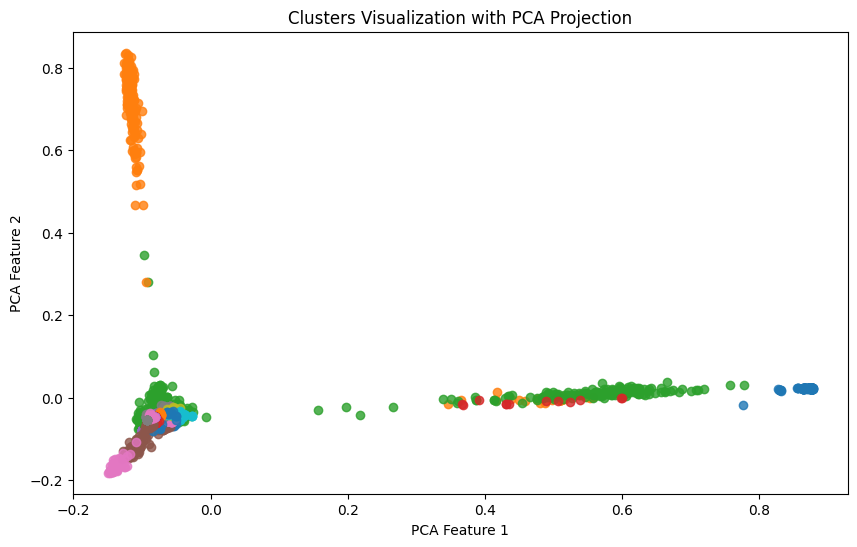

In [15]:
import matplotlib.pyplot as plt

# Perform PCA to reduce the TF-IDF features to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())  # Ensure it's in dense format for PCA

plt.figure(figsize=(10, 6))

# Plot each cluster
unique_clusters = set(clusters)
for cluster in unique_clusters:
    if cluster != -1:
        cluster_indices = np.where(clusters == cluster)[0]
        # Assign different alpha values for noise and non-noise clusters
        alpha_value = 0.01 if cluster == -1 else 0.8  # Make noise points more transparent
        plt.scatter(reduced_features[cluster_indices, 0], reduced_features[cluster_indices, 1], alpha=alpha_value, label=f'Cluster {cluster}' if cluster != -1 else 'Noise')

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Clusters Visualization with PCA Projection')
plt.show()


**Sample from each cluster:**

In [16]:
def sample_from_clusters(clusters, dataset, samples_per_cluster):
    """ Sample a fixed number of examples from each cluster """
    unique_clusters = set(clusters) - {-1}  # Exclude noise cluster
    sampled_indices = []

    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        sampled_cluster_indices = random.sample(list(cluster_indices), min(len(cluster_indices), samples_per_cluster))
        sampled_indices.extend(sampled_cluster_indices)

    return list(sampled_indices)

In [17]:
def sample_from_noise(clusters, dataset, min_count):
    """ Sample a fixed number of examples from the noise cluster """
    noise_indices = np.where(clusters == -1)[0]
    sampled_indices = []

    if len(noise_indices) > 0:
        sampled_noise_indices = random.sample(list(noise_indices), min(len(noise_indices), min_count))
        sampled_indices.extend(sampled_noise_indices)

    return list(sampled_indices)


In [18]:
samples_per_cluster = 3

# Sample from clusters excluding noise
sampled_cluster_indices = sample_from_clusters(clusters, dataset_negative_examples, samples_per_cluster)
print("Sampled clusters dataset:", len(sampled_cluster_indices))

# Sample from noise
remaining_noise_quota = min_count - len(sampled_cluster_indices)
sampled_noise_indices = sample_from_noise(clusters, dataset_negative_examples, remaining_noise_quota)
print("Sampled noise dataset:", len(sampled_noise_indices))

# Combine indices of all sampled and non-sampled examples
all_sampled_indices = set(sampled_cluster_indices + sampled_noise_indices)
all_indices = set(range(len(dataset_negative_examples)))
non_sampled_indices = list(all_indices - all_sampled_indices)

sampled_dataset = dataset_negative_examples.select(sampled_cluster_indices + sampled_noise_indices)
discarded_dataset = dataset_negative_examples.select(non_sampled_indices)

Sampled clusters dataset: 84
Sampled noise dataset: 121


In [19]:
balanced_dataset = concatenate_datasets([sampled_dataset, dataset_positive_examples])

label_counts = Counter(balanced_dataset['label'])
print("Class frequencies:", label_counts)

Class frequencies: Counter({0: 205, 1: 205})


**Split in Test and Train Dataset**

In [20]:
print("Number of all annotated samples:", len(balanced_dataset))

dataset_pos = balanced_dataset.filter(lambda example: example['label'] > 0)
print("Number of positive annotated samples:", len(dataset_pos))

dataset_buff = balanced_dataset.filter(lambda example: example['category'] == "buff")
print("Number of manually annotated samples:", len(dataset_buff))

dataset_not_buff = balanced_dataset.filter(lambda example: example['category'] != "buff")
print("Number of regular annotated samples:", len(dataset_not_buff))

Number of all annotated samples: 410


Filter: 100%|██████████| 410/410 [00:00<00:00, 15308.91 examples/s]


Number of positive annotated samples: 205


Filter: 100%|██████████| 410/410 [00:00<00:00, 15665.50 examples/s]


Number of manually annotated samples: 150


Filter: 100%|██████████| 410/410 [00:00<00:00, 15445.30 examples/s]

Number of regular annotated samples: 260


In [21]:
def train_test_split_balanced(dataset: Dataset, n: int, label_column='label', random_state=None):
    """Randomly sample n/2 datapoints from each class for the test set and return the train and test splits. """
    
    # If n is odd, increment by 1 to make it even
    if n % 2 != 0:
        n += 1
    
    if random_state is not None:
        random.seed(random_state)
    
    # Aggregate indices by class
    class_indices = {label: [i for i, example in enumerate(dataset) if example[label_column] == label] 
                     for label in set(dataset[label_column])}
    
    # Ensure there are enough samples in each class
    for label, indices in class_indices.items():
        if len(indices) < n // 2:
            raise ValueError(f"Not enough samples in class {label} to sample {n // 2} examples.")
    
    # Randomly sample n/2 indices from each class for the test set
    test_indices = []
    for indices in class_indices.values():
        test_indices.extend(random.sample(indices, n // 2))
    
    # Determine train indices by finding the difference between all indices and the test ones
    all_indices = set(range(len(dataset)))
    test_set = set(test_indices)
    train_indices = list(all_indices - test_set)
    
    # Select the train and test indices to create new datasets
    train_dataset = dataset.select(train_indices)
    test_dataset = dataset.select(test_indices)
    
    return DatasetDict({'train': train_dataset, 'test': test_dataset})

In [22]:
test_size_int = round(len(balanced_dataset) * 0.1)
print("Test size:", test_size_int)

Test size: 41


In [23]:
split_datasets = train_test_split_balanced(dataset_not_buff, n=test_size_int, label_column='label')
split_datasets['train'] = concatenate_datasets([split_datasets['train'], dataset_buff])
print("Size of training set:", len(split_datasets['train']))
print("Size of testing set:", len(split_datasets['test']))

Size of training set: 368
Size of testing set: 42


In [24]:
# Count the occurrences of each label
label_counts = Counter(split_datasets["test"]['label'])
print("Class frequencies:", label_counts)

Class frequencies: Counter({0: 21, 1: 21})


In [25]:
split_datasets 

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count'],
        num_rows: 368
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count'],
        num_rows: 42
    })
})

**Save Splits:**

In [26]:
dataset_split["train"] = balanced_dataset

In [27]:
dataset_split.save_to_disk(f"../../data/tmp/processed_dataset_{topic}_clustered_random")

Saving the dataset (0/1 shards):   0%|          | 0/410 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 46/46 [00:00<00:00, 4941.05 examples/s]


In [28]:
## Save with discarded URLs
dataset_split["holdout"] = discarded_dataset
dataset_split.save_to_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_clustered_holdout")

Saving the dataset (1/1 shards): 100%|██████████| 3448/3448 [00:00<00:00, 22117.89 examples/s]


In [29]:
dataset_extented = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_extended_filtered")

In [30]:
dataset_split["extended"] = dataset_extented
dataset_split.save_to_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_clustered_extended")

Saving the dataset (1/1 shards): 100%|██████████| 44432/44432 [00:00<00:00, 88040.21 examples/s] 
